In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from diveslowlearnfast.train import StatsDB
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tools.visualise import plot_confusion_matrix, plot_per_class_accuracy
import matplotlib.animation as animation
from IPython.display import HTML

import torch

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.egl.explainer import ExplainerStrategy
from diveslowlearnfast.train.helper import get_test_transform
from diveslowlearnfast.models import SlowFast, load_checkpoint
from diveslowlearnfast.config import Config
from diveslowlearnfast.visualise.gradcam import GradCAM
from diveslowlearnfast.train import helper as train_helper, StatsDB
from diveslowlearnfast.visualise.gradcam import GradCAM
from diveslowlearnfast.visualise.create_heatmap import create_heatmaps
from diveslowlearnfast.egl import helper as egl_helper
from diveslowlearnfast.visualise.create_heatmap import revert_tensor_normalize

import matplotlib

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

stats_run19 = StatsDB('./data/stats_run19.db')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
stats_run19.execute_query("SELECT MAX(epoch) FROM stats")

[[122]]

In [4]:
stats_run19.execute_query("SELECT DISTINCT(run_id) FROM stats")

[['/home/s2871513/Projects/diveslowlearnfast/results/run19']]

In [5]:
samples = stats_run19.get_below_median_samples(
    epoch_start=110,
    run_id='/home/s2871513/Projects/diveslowlearnfast/results/run19',
    split='train'
)


In [6]:
stats_run19.execute_query("SELECT COUNT(DISTINCT(video_id)) FROM stats")

[[16997]]

In [7]:
result = stats_run19.execute_query("""SELECT gt, pred FROM stats
WHERE epoch = 120 AND split = "test"
""")
result = np.array(result)
Y_true = result[:, 0]
Y_pred = result[:, 1]
labels = np.unique(Y_true)

In [8]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_true, Y_pred, average='macro')

cnf_mat = confusion_matrix(Y_true, Y_pred, labels=labels)
precision, recall, f1, (Y_true == Y_pred).sum() / len(Y_true)

(0.7718521756813207, 0.6933993716277834, 0.702305073641471, 0.7883248730964467)

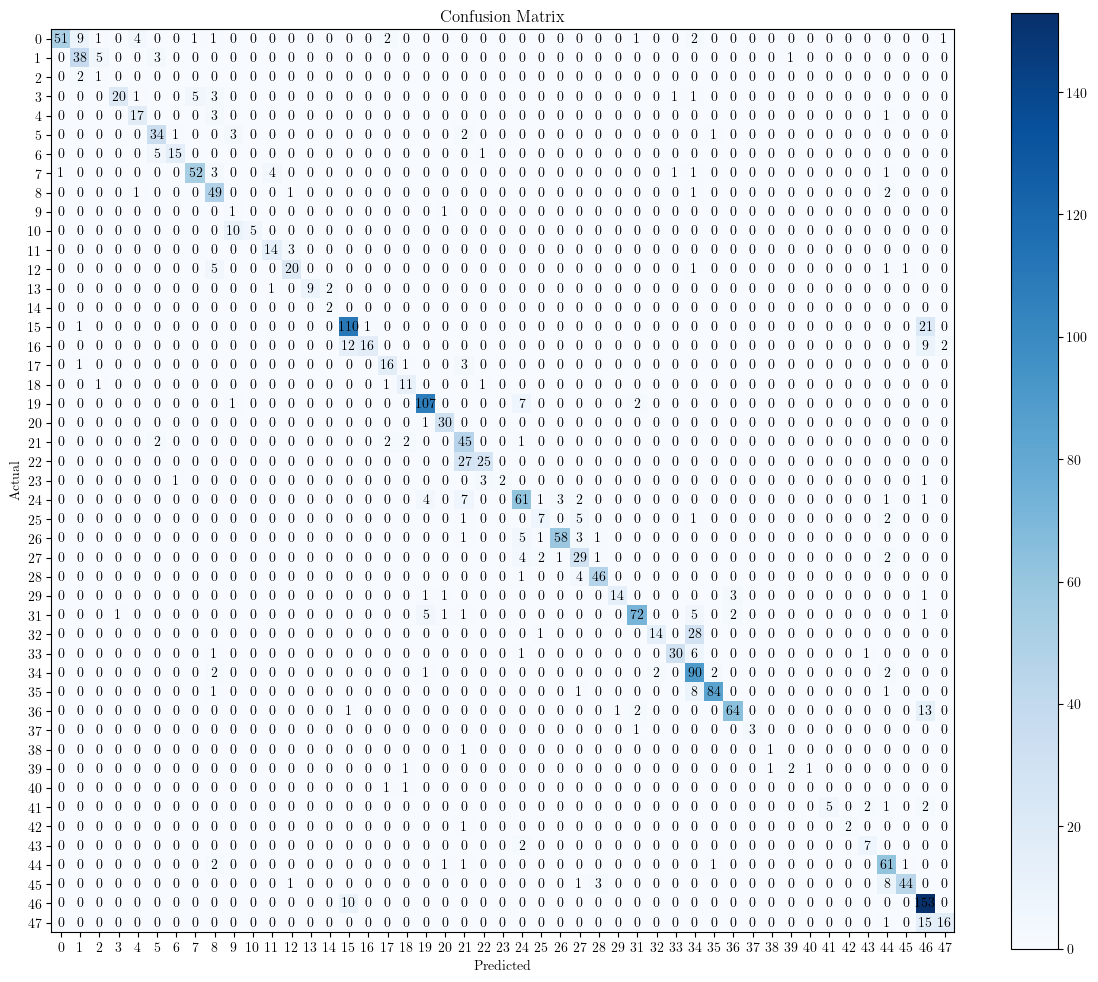

In [9]:
from pathlib import Path

cnf_mat_norm = np.uint16((cnf_mat - cnf_mat.min()) / (cnf_mat.max() - cnf_mat.min()) * 100)
plot_confusion_matrix(cnf_mat, save_path='confusion_matrix.png', labels=labels)

AttributeError: 'str' object has no attribute 'parent'

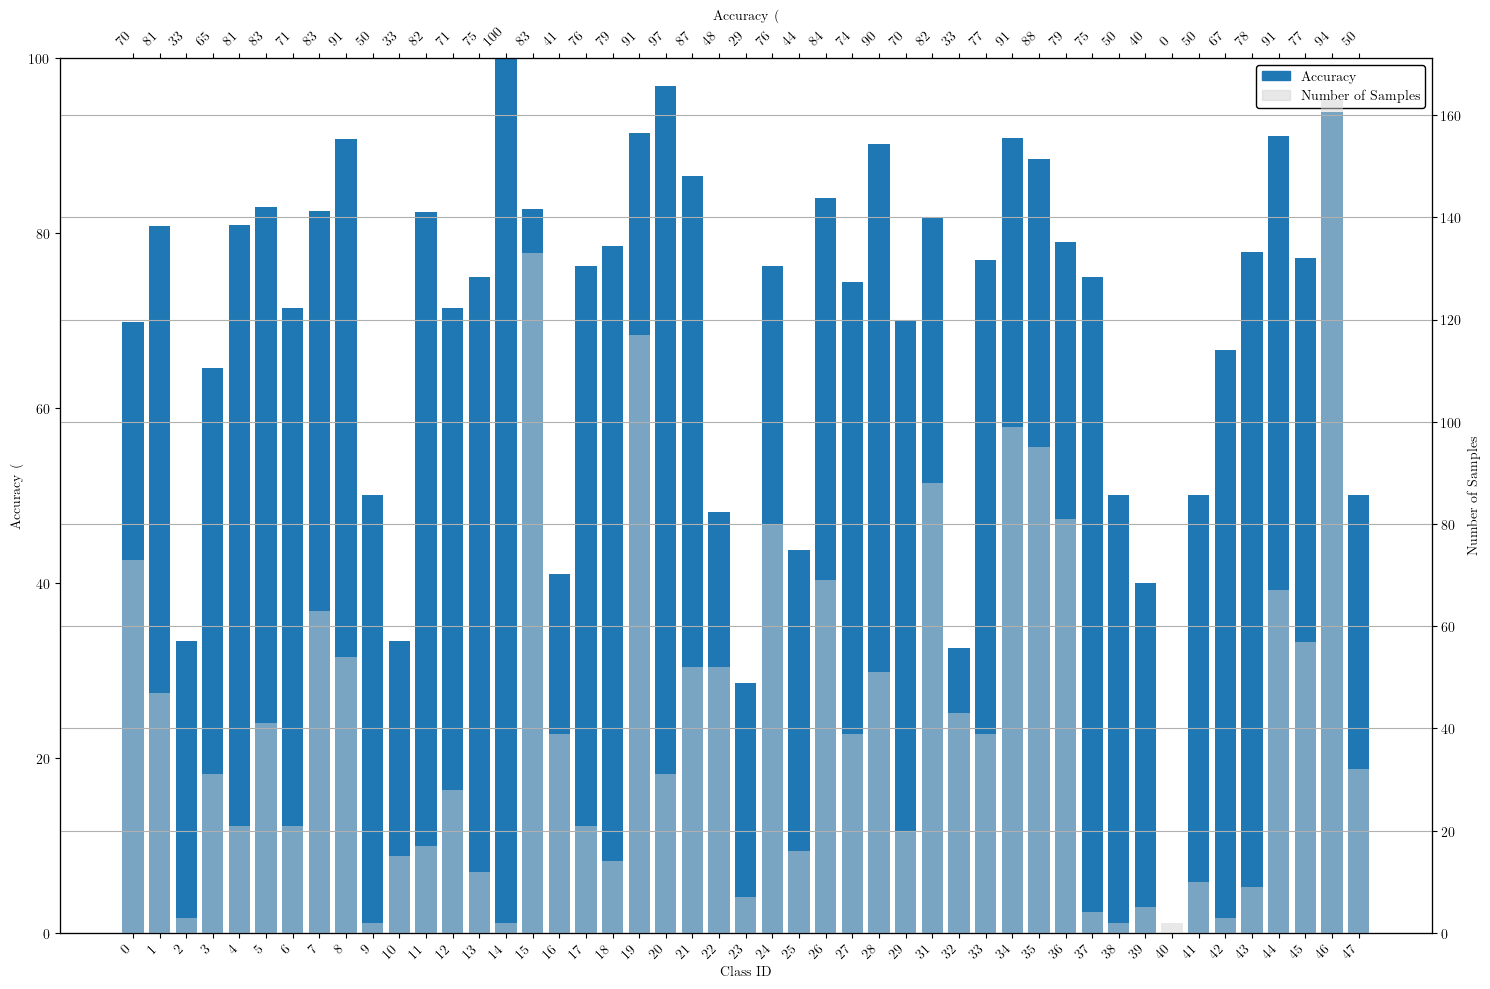

In [10]:
plot_per_class_accuracy(cnf_mat, './', labels=labels)

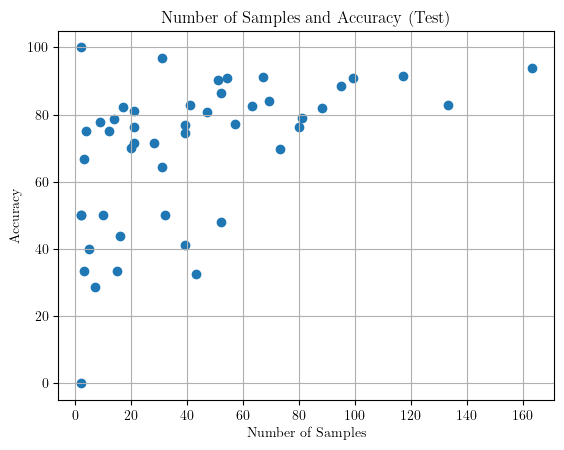

In [12]:
Y_true, Y_pred, _ = stats_run19.get_ytrue_and_pred(
    120,
    '/home/s2871513/Projects/diveslowlearnfast/results/run19',
    'test'
)

cnf_mat = confusion_matrix(Y_true, Y_pred, labels=labels)
totals = np.array(cnf_mat.sum(axis=1)) + 1e-9
diagonals = np.array(cnf_mat.diagonal())
per_class_accuracy = (diagonals / totals) * 100

plt.scatter(totals, per_class_accuracy)
plt.title('Samples vs. Accuracy on Test set')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.grid()
plt.savefig('./scatter_samples_vs_accuracy_test.png')
plt.show()

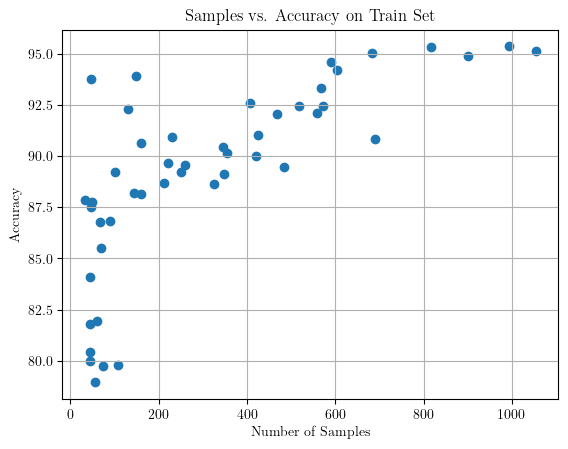

In [15]:
Y_true, Y_pred, _ = stats_run19.get_ytrue_and_pred(
    120,
    '/home/s2871513/Projects/diveslowlearnfast/results/run19',
    'train'
)

cnf_mat = confusion_matrix(Y_true, Y_pred, labels=labels)
totals = np.array(cnf_mat.sum(axis=1)) + 1e-9
diagonals = np.array(cnf_mat.diagonal())
per_class_accuracy = (diagonals / totals) * 100

plt.scatter(totals, per_class_accuracy)
plt.title('Samples vs. Accuracy on Train Set')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.grid()
plt.savefig('./scatter_samples_vs_accuracy_train.png')
plt.show()

In [ ]:
# class 22 is being confused with class 21, let's find out why
results = stats_run19.execute_query("""SELECT video_id, gt, pred FROM stats
WHERE epoch = 120 AND split = "test" AND gt IN (46, 47)
""")
results

In [ ]:
cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 8
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']
device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model, device)
model, *_ = load_checkpoint(model, optimiser, '../../misc/checkpoint.pth', device)
explainer = ExplainerStrategy.get_explainer(model, cfg=cfg, device=device)

test_dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='test',
    transform_fn=get_test_transform(cfg), # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_dynamic_temporal_stride=cfg.DATA.USE_DYNAMIC_TEMPORAL_STRIDE,
    include_labels=[46, 47]
)

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)


std = np.array(cfg.DATA.STD)
mean = np.array(cfg.DATA.MEAN)

def vidshow(video, interval, title=None, axis='on'):
    fig = plt.figure()
    plt.ioff()  # Turn off interactive mode
    ax = fig.add_subplot(111)
    if title is not None:
        ax.set_title(title)

    img = ax.imshow(video[0])
    ax.axis(axis)
    def _update(frame):
        img.set_data(video[frame])

    ani = animation.FuncAnimation(fig, _update, frames=len(video), interval=interval)

    return HTML(ani.to_jshtml()), ani

def vidshow2(videos, titles, interval, axis='on'):
    fig = plt.figure()
    plt.ioff()  # Turn off interactive mode
    axes = fig.subplots(1, len(videos))

    imgs = []
    for ax, video, title in zip(axes, videos, titles):
        ax.set_title(title)
        img = ax.imshow(video[0])
        imgs.append(img)
        ax.axis(axis)

    def _update(frame):
        for ax, img, video in zip(axes, imgs, videos):
            img.set_data(video[frame])


    ani = animation.FuncAnimation(fig, _update, frames=videos[0].shape[0], interval=interval)

    return HTML(ani.to_jshtml()), ani


def denormalise_tensor(tensor, mean, std):
    if tensor.ndim == 5:
        return tensor.numpy().transpose(0, 2, 3, 4, 1) * std[None, None, None, None, :] + mean[None, None, None, None, :]

    return tensor.numpy().transpose(1, 2, 3, 0) * std[None, None, None, :] + mean[None, None, None, :]

In [ ]:
xb, yb, _, _, video_ids, _ = next(iter(test_loader))

In [ ]:
yb

In [ ]:
denormalized_video = xb.numpy().transpose(0, 2, 3, 4, 1) * std[None, None, None, None, :] + mean[None, None, None, None, :]
denormalized_video = np.clip(denormalized_video, 0, 1)  # if original was 0-1

In [ ]:
idx_left = 1
idx_right = 0
video_left = denormalized_video[idx_left]
video_right = denormalized_video[idx_right]
title_left = ', '.join(test_dataset.get_label(yb[idx_left].item()))
title_right = ', '.join(test_dataset.get_label(yb[idx_right].item()))

html, ani = vidshow2(
    [video_left, video_right],
    [title_left, title_right],
    interval=240,
    axis='off'
)
ani.save(filename=f"./classes_46_47_vid.gif", writer="pillow")
html

In [ ]:
model.eval()
gc = GradCAM(model, ['s5/pathway0_res2', 's5/pathway1_res2'], cfg.DATA.MEAN, cfg.DATA.STD)

In [ ]:
xb_fast = xb[:].to(device)
# reduce the number of frames by the alpha ratio
# B x C x T / alpha x H x W
xb_slow = xb[:, :, ::cfg.SLOWFAST.ALPHA].to(device)
_, maps, preds = gc([xb_slow, xb_fast])

In [ ]:
preds = preds.argmax(dim=-1)
preds, yb

In [ ]:
heatmaps = create_heatmaps([xb_slow, xb_fast], maps, cfg.DATA.MEAN, cfg.DATA.STD)

In [ ]:
videos_slow = heatmaps[0].numpy().transpose(0, 1, 3, 4, 2)

In [ ]:
idx_left = 1
idx_right = 0
video_left = videos_slow[idx_left]
video_right = videos_slow[idx_right]
title_left = ', '.join(test_dataset.get_label(yb[idx_left].item()))
title_right = ', '.join(test_dataset.get_label(yb[idx_right].item()))

html, ani = vidshow2(
    [video_left, video_right],
    [title_left, title_right],
    interval=240,
    axis='off'
)
ani.save(filename=f"./classes_46_47_slow_grad.gif", writer="pillow")
html

In [ ]:
videos_fast = heatmaps[1].numpy().transpose(0, 1, 3, 4, 2)
idx_left = 1
idx_right = 0
video_left = videos_fast[idx_left]
video_right = videos_fast[idx_right]
title_left = ', '.join(test_dataset.get_label(yb[idx_left].item()))
title_right = ', '.join(test_dataset.get_label(yb[idx_right].item()))

html, ani = vidshow2(
    [video_left, video_right],
    [title_left, title_right],
    interval=240,
    axis='off'
)
ani.save(filename=f"./classes_46_47_fast_grad.gif", writer="pillow")
html

In [ ]:
results = stats_run19.execute_query("""SELECT video_id, gt, pred FROM stats
WHERE epoch = 120 AND split = "test" AND gt IN (46, 47)
""")

results

In [ ]:
# video_id='8qRmKunCjtY_00004', gt=46, pred=46
video_01, *_ = test_dataset._read_frames('8qRmKunCjtY_00004')
# video_id='ovWCmIMMkRI_00052', gt=47, pred=47
video_02, *_ = test_dataset._read_frames('ovWCmIMMkRI_00052')

In [ ]:
xb = video_01.unsqueeze(0)
xb_fast = xb[:].to(device)
# reduce the number of frames by the alpha ratio
# B x C x T / alpha x H x W
xb_slow = xb[:, :, ::cfg.SLOWFAST.ALPHA].to(device)
inputs = [xb_slow, xb_fast]
_, maps, preds = gc(inputs)
heatmaps = create_heatmaps(inputs, maps, cfg.DATA.MEAN, cfg.DATA.STD)

In [ ]:
html, ani = vidshow(
    denormalise_tensor(video_01, mean, std),
    interval=240,
    axis='off'
)
html

In [ ]:
heatmaps[0].squeeze(0).permute(0, 2, 3, 1).shape

In [ ]:
html, ani = vidshow(
    heatmaps[0].squeeze(0).permute(0, 2, 3, 1),
    interval=240,
    axis='off'
)
html

In [ ]:
html, ani = vidshow(
    heatmaps[1].squeeze(0).permute(0, 2, 3, 1),
    title='-'.join(test_dataset.get_label(46)),
    interval=240,
    axis='off'
)
plt.close('all')
ani.save(f'./8qRmKunCjtY_00004_46_46_{'-'.join(test_dataset.get_label(46))}.gif', writer="pillow")
html